# Exploratory Data Analysis

In [1]:
!pip install geopandas

In [2]:
!pip install geopy

In [3]:
!pip install pygeos

In [4]:
!pip install geojson

In [5]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [6]:
!sudo pip3 install rtree

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly
import plotly.offline as py
import plotly.graph_objs as go

import geopandas as gpd
import geopy as gp
import shapely
import geojson
import rtree
import pygeos

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning:

The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.



In [8]:
from shapely.geometry import MultiPolygon
from shapely.geometry import shape

## OpenStreetMaps

In [ ]:
!pip install overpy

     |████████████████████████████████| 47 kB 3.9 MB/s 
  Created wheel for overpy: filename=overpy-0.6-py3-none-any.whl size=14107 sha256=f89f6566bc7bea2c1d6a0368f1342743570b3cb428a3576901af0768d1082bc7
  Stored in directory: /root/.cache/pip/wheels/1a/d3/0e/090c6914956cc37881fc914101d2a952c0da8e66fc86dc6a31
Successfully built overpy


In [ ]:
import overpy
api = overpy.Overpass()

In [ ]:
r = api.query("""
[out:json];

area[name="Chicago"]->.a;

( node(area.a)[amenity=hospital];
);

out;
""")

In [ ]:
r = api.query("""

[out:csv(::id,::type,"name","addr:postcode","addr:city","addr:street","addr:housenumber","website"," contact:email=*")][timeout:600];

area[name="Chicago"]->.a;

( node(area.a)[amenity=hospital];

  way(area.a)[amenity=hospital];

  rel(area.a)[amenity=hospital];);

out center;
""")

# Boundaries - Census Blocks 2010

In [9]:
url = 'https://data.cityofchicago.org/resource/bt9m-d2mf.json'
blocks = pd.read_json(url)

In [10]:
blocks['the_geom'].head()

0    {'type': 'MultiPolygon', 'coordinates': [[[[-8...
1    {'type': 'MultiPolygon', 'coordinates': [[[[-8...
2    {'type': 'MultiPolygon', 'coordinates': [[[[-8...
3    {'type': 'MultiPolygon', 'coordinates': [[[[-8...
4    {'type': 'MultiPolygon', 'coordinates': [[[[-8...
Name: the_geom, dtype: object

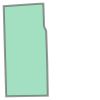

In [11]:
shape(blocks['the_geom'][1])

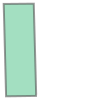

In [12]:
shape(blocks['the_geom'][45])

In [13]:
new_geom = []
for index, row in blocks.iterrows():
  new_geom.append(shape(row['the_geom']))
new_geom = pd.DataFrame(new_geom)
new_geom
blocks['the_geom'] = new_geom

In [14]:
blocks_geo = gpd.GeoDataFrame(blocks).set_geometry('the_geom')

## Parks

In [15]:
url = 'https://data.cityofchicago.org/resource/2eaw-bdhe.json'
parks = pd.read_json(url)

In [16]:
parks.head()

,park_name,bowling_green,gymnastic_centers,:@computed_region_43wa_7qmu,band_shell,wheelchair_accessible_ball_fields,boat_slips,volleyball_sand,park_class,alfred_caldwell_lily_pond,location,lagoon,casting_area,nature_center,sport_roller_courts,baseball_jr_softball_t_ball,baseball_sr,baseball_batting_cages,sled_hill,wetland_area,fitness_center,bocce_court,pool_indoor,cultural_center,carousel,water_playground,community_garden,gymnasium,golf_putting_greens,skate_park,acres,gallery,cricket_field,model_train_display,boat_launch_non_motorized,rowing_club,pool_outdoor,:@computed_region_rpca_8um6,basketball_backboards,shuffleboard,...,pavillion,conservatory,handball_raquetball_court,horseshoe_courts,boat_launch_motorized,ice_skating,ward,model_yacht_basin,zip,tennis_courts,beach,street_address,golf_course,chess_pavillion,spray_feature,golf_course_miniature,basketball_courts,handball,zoo,football_soccer_combo,water_slide,senior_center,:@computed_region_bdys_3d7i,mountain_bike_trail,:@computed_region_6mkv_f3dw,park_number,dog_friendly,playground_park,artificial_turf_fields,boxing_center,playground,label,fitness_courses,track,garden,golf_driving_range,archery_range,:@computed_region_vrxf_vc4k,volleyball,croquet
0,MCKEON (JOSEPH),0,0,48.0,0,0,0,0,MINI-PARK,0,"{'latitude': '41.82903552510654', 'human_addre...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.40,0,0,0,0,0,0,37.0,0,0,...,0,0,0,0,0,0,11,0,60609.0,0,0,600 W 36TH ST,0,0,0,0,0,0,0,0,0,0,172.0,0,14924.0,1162,0,1,0,0,0,McKeon,0,0,0,0,0,58.0,0,0
1,OHIO,0,0,23.0,0,0,0,0,MINI-PARK,0,"{'latitude': '41.89145773962588', 'human_addre...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.42,0,0,0,0,0,0,32.0,2,0,...,0,0,0,0,0,0,37,0,60644.0,0,0,4712 W OHIO ST,0,0,1,0,1,0,0,0,0,0,695.0,0,22216.0,1139,0,0,0,0,1,Ohio,0,0,0,0,0,26.0,0,0
2,ALTGELD (JOHN),0,0,23.0,0,0,0,0,COMMUNITY PARK,0,"{'latitude': '41.87472755936259', 'human_addre...",0,0,0,0,3,1,0,0,0,1,0,0,0,0,0,0,1,0,0,4.32,0,0,0,0,0,1,28.0,2,0,...,0,0,0,0,0,0,27,0,60612.0,0,0,515 S WASHTENAW AVE,0,0,0,0,1,0,0,1,0,0,38.0,0,21184.0,206,0,0,0,0,1,Altgeld,0,0,0,0,0,28.0,0,0
3,PARK NO. 468,0,0,15.0,0,0,0,0,UNIMPROVED PARK,0,"{'latitude': '41.791344140064204', 'human_addr...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.32,0,0,0,0,0,0,58.0,0,0,...,0,0,0,0,0,0,13,0,60629.0,0,0,4556 W 56TH ST,0,0,0,0,0,0,0,0,0,0,773.0,0,21867.0,468,0,0,0,0,0,Park No. 468,0,0,0,0,0,60.0,0,0
4,RAINEY (EDWARD),0,0,30.0,0,0,0,0,REGIONAL PARK,0,"{'latitude': '41.749472777639994', 'human_addr...",0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,18.31,0,0,0,0,0,0,8.0,0,0,...,0,0,0,0,0,0,13,0,60652.0,3,0,4350 W 79TH ST,0,0,0,0,0,0,0,1,0,0,571.0,0,4300.0,33,0,0,0,0,1,Rainey,0,0,0,0,0,69.0,1,0


In [17]:
parks["location"][0]

{'human_address': '{"address": "600 W 36TH ST", "city": "", "state": "", "zip": "60609"}',
 'latitude': '41.82903552510654',
 'longitude': '-87.64121494764093',
 'needs_recoding': False}

In [18]:
n_parks = parks.shape[0]

In [19]:
lat_col = []
lon_col = []
for i in range(n_parks):
  location = parks.location[i]
  try:
    #print(location['latitude'])
    lat_col.append(location['latitude'])
    lon_col.append(location['longitude'])
  except:
    lat_col.append(np.nan)
    lon_col.append(np.nan)

In [20]:
parks['latitude'] = lat_col
parks['longitude'] = lon_col

In [21]:
parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 83 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   park_name                          581 non-null    object 
 1   bowling_green                      581 non-null    int64  
 2   gymnastic_centers                  581 non-null    int64  
 3   :@computed_region_43wa_7qmu        577 non-null    float64
 4   band_shell                         581 non-null    int64  
 5   wheelchair_accessible_ball_fields  581 non-null    int64  
 6   boat_slips                         581 non-null    int64  
 7   volleyball_sand                    581 non-null    int64  
 8   park_class                         581 non-null    object 
 9   alfred_caldwell_lily_pond          581 non-null    int64  
 10  location                           580 non-null    object 
 11  lagoon                             581 non-null    int64  

In [22]:
parks.describe()

,bowling_green,gymnastic_centers,:@computed_region_43wa_7qmu,band_shell,wheelchair_accessible_ball_fields,boat_slips,volleyball_sand,alfred_caldwell_lily_pond,lagoon,casting_area,nature_center,sport_roller_courts,baseball_jr_softball_t_ball,baseball_sr,baseball_batting_cages,sled_hill,wetland_area,fitness_center,bocce_court,pool_indoor,cultural_center,carousel,water_playground,community_garden,gymnasium,golf_putting_greens,skate_park,acres,gallery,cricket_field,model_train_display,boat_launch_non_motorized,rowing_club,pool_outdoor,:@computed_region_rpca_8um6,basketball_backboards,shuffleboard,:@computed_region_awaf_s7ux,pavillion,conservatory,handball_raquetball_court,horseshoe_courts,boat_launch_motorized,ice_skating,ward,model_yacht_basin,zip,tennis_courts,beach,golf_course,chess_pavillion,spray_feature,golf_course_miniature,basketball_courts,handball,zoo,football_soccer_combo,water_slide,senior_center,:@computed_region_bdys_3d7i,mountain_bike_trail,:@computed_region_6mkv_f3dw,park_number,dog_friendly,playground_park,artificial_turf_fields,boxing_center,playground,fitness_courses,track,garden,golf_driving_range,archery_range,:@computed_region_vrxf_vc4k,volleyball,croquet
count,581.000000,581.000000,577.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,577.000000,581.000000,581.000000,577.000000,581.0,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,580.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,577.000000,581.000000,577.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,577.000000,581.000000,581.000000
mean,0.003442,0.013769,26.131716,0.001721,0.003442,0.166954,0.058520,0.001721,0.030981,0.020654,0.001721,0.029260,0.958692,0.277108,0.003442,0.001721,0.008606,0.129088,0.020654,0.046472,0.012048,0.001721,0.034423,0.039587,0.247849,0.005164,0.008606,14.104458,0.005164,0.006885,0.001721,0.008606,0.001721,0.086059,28.365685,1.354561,0.022375,26.521664,0.0,0.003442,0.001721,0.123924,0.005164,0.013769,24.648881,0.001721,60628.951724,0.986231,0.046472,0.012048,0.003442,0.330465,0.001721,0.573150,0.018933,0.001721,0.449225,0.008606,0.005164,410.020797,0.001721,18959.109185,577.808950,0.027539,0.230637,0.048193,0.017212,0.662651,0.005164,0.046472,0.032702,0.005164,0.001721,37.076256,0.036145,0.003442
std,0.082974,0.116633,14.537905,0.041487,0.058621,3.737694,0.255998,0.041487,0.209442,0.142346,0.041487,0.168679,1.862983,0.646457,0.058621,0.041487,0.092447,0.335586,0.202366,0.210686,0.109195,0.041487,0.182471,0.195155,0.477619,0.071734,0.092447,68.827237,0.071734,0.165948,0.041487,0.092447,0.041487,0.280692,18.195783,2.295032,0.323529,15.472869,0.0,0.058621,0.041487,0.668345,0.071734,0.116633,15.448266,0.041487,15.110225,2.656122,0.331520,0.109195,0.058621,0.492269,0.041487,0.957854,0.206747,0.041487,0.994599,0.092447,0.071734,234.926820,0.041487,5846.645520,413.824975,0.192799,0.421603,0.258145,0.130172,0.807166,0.071734,0.210686,0.205017,0.071734,0.041487,22.088075,0.195823,0.058621
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60602.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4299.000000,2.000000

In [23]:
parks.isnull().sum()

park_name                      0
bowling_green                  0
gymnastic_centers              0
:@computed_region_43wa_7qmu    4
band_shell                     0
                              ..
:@computed_region_vrxf_vc4k    4
volleyball                     0
croquet                        0
latitude                       4
longitude                      4
Length: 83, dtype: int64

## Crime

In [24]:
url = "https://data.cityofchicago.org/resource/dfnk-7re6.json"
crime = pd.read_json(url)

In [25]:
crime.tail()

,case_,date_of_occurrence,block,_primary_decsription,fbi_cd,_secondary_description,ward,_location_description,domestic,beat,_iucr,arrest,:@computed_region_43wa_7qmu,location,y_coordinate,latitude,:@computed_region_awaf_s7ux,x_coordinate,longitude,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k
995,JD469614,2020-12-26T04:13:00.000,015XX W THORNDALE AVE,CRIMINAL DAMAGE,14,TO VEHICLE,48,STREET,N,2013,1320,N,16.0,"{'latitude': '41.989932813', 'human_address': ...",1939623.0,41.989933,40.0,1164990.0,-87.668497,539.0,4451.0,76.0
996,JE224151,2021-05-08T22:44:00.000,039XX S WESTERN AVE,THEFT,06,$500 AND UNDER,12,SIDEWALK,N,921,0820,N,1.0,"{'latitude': '41.8229272', 'human_address': '{...",1878732.0,41.822927,29.0,1161005.0,-87.684847,718.0,14924.0,55.0
997,JE228481,2021-03-26T11:00:00.000,058XX N GLENWOOD AVE,DECEPTIVE PRACTICE,12,EMBEZZLEMENT,48,ATHLETIC CLUB,N,2013,1140,N,16.0,"{'latitude': '41.987198852', 'human_address': ...",1938634.0,41.987199,40.0,1165932.0,-87.665060,539.0,4451.0,76.0
998,JD469569,2020-12-26T01:30:00.000,025XX E 78TH ST,CRIMINAL DAMAGE,14,TO PROPERTY,7,RESIDENCE,Y,421,1310,N,37.0,"{'latitude': '41.753587834', 'human_address': ...",1853739.0,41.753588,43.0,1194402.0,-87.563150,246.0,22538.0,39.0
999,JD469945,2020-12-26T07:45:00.000,0000X S MASON AVE,BATTERY,08B,DOMESTIC BATTERY SIMPLE,29,SIDEWALK,Y,1513,0486,Y,7.0,"{'latitude': '41.879783007', 'human_address': ...",1899281.0,41.879783,52.0,1136839.0,-87.773012,67.0,22216.0,26.0


In [26]:
crime.describe()

,ward,beat,:@computed_region_43wa_7qmu,y_coordinate,latitude,:@computed_region_awaf_s7ux,x_coordinate,longitude,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k
count,1000.00000,1000.000000,977.000000,9.820000e+02,982.000000,978.000000,9.820000e+02,982.000000,979.000000,982.000000,977.000000
mean,23.91700,1192.135000,25.233367,1.887968e+06,41.848183,27.317996,1.164535e+06,-87.671680,384.751788,19355.813646,37.405322
std,14.18391,705.546518,13.957150,3.244369e+04,0.089224,15.281062,1.612892e+04,0.058673,231.641234,5593.547822,20.027836
min,1.00000,111.000000,1.000000,1.815798e+06,41.649349,1.000000,1.101811e+06,-87.900984,1.000000,4299.000000,1.000000
25%,9.75000,614.000000,13.000000,1.859115e+06,41.768944,13.000000,1.152212e+06,-87.716342,178.000000,21186.000000,24.000000
50%,24.00000,1113.000000,25.000000,1.894496e+06,41.866337,28.000000,1.165706e+06,-87.666796,383.000000,21564.500000,34.000000
75%,35.00000,1732.250000,36.000000,1.912550e+06,41.915887,41.000000,1.176558e+06,-87.628043,581.500000,22216.000000,57.000000
max,50.00000,2535.000000,50.000000,1.950352e+06,42.019440,53.000000,1.201497e+06,-87.537698,800.000000,26615.000000,77.000000


In [28]:
crime.isnull().sum()

case_                           0
date_of_occurrence              0
block                           0
_primary_decsription            0
fbi_cd                          0
_secondary_description          0
ward                            0
_location_description           6
domestic                        0
beat                            0
_iucr                           0
arrest                          0
:@computed_region_43wa_7qmu    23
location                       18
y_coordinate                   18
latitude                       18
:@computed_region_awaf_s7ux    22
x_coordinate                   18
longitude                      18
:@computed_region_bdys_3d7i    21
:@computed_region_6mkv_f3dw    18
:@computed_region_vrxf_vc4k    23
dtype: int64

## Energy use

In [29]:
url = "https://data.cityofchicago.org/resource/jn94-it7m.json"
energy_use = pd.read_json(url)

In [30]:
energy_use.head()

,location,benchmarking_id,address,chicago_energy_rating,latitude,exempt_from_chicago_energy_rating,community_area,longitude,property_name,data_year,reporting_status,zip_code,number_of_buildings,primary_property_type_epa_calculated,site_eui_kbtu_sq_ft,property_gross_floor_area_epa_calculated_buildings_sq_ft,natural_gas_use_kbtu,year_built,electricity_use_grid_purchase_and_generated_from_onsite_renewable_systems_kbtu,energy_star_score,weather_normalized_site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,water_use_kgal,total_ghg_emissions_metric_tons_co2e,ghg_intensity_metric_tons_co2e_sq_ft,district_chilled_water_use_kbtu,district_steam_use_kbtu
0,"{'latitude': '41.70649646', 'needs_recoding': ...",159005,821 E 103rd St,0.0,41.706496,False,PULLMAN,-87.602690,Corliss HS -CPS,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"{'latitude': '41.886495', 'needs_recoding': Fa...",256568,363 E Wacker Dr,0.0,41.886495,False,Loop,-87.618105,Vista Tower,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{'latitude': '41.75582921', 'needs_recoding': ...",100393,7601 S Cicero Ave,NaN,41.755829,True,WEST LAWN,-87.736993,Ford City Mall,2019,Submitted,60652,1.0,Enclosed Mall,144.1,864923.0,11780942.4,1950.0,112895334.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"{'latitude': '41.75629268', 'needs_recoding': ...",100395,7500 S Pulaski Ave,0.0,41.756293,False,WEST LAWN,-87.722240,Daley,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"{'latitude': '42.01036185', 'needs_recoding': ...",100984,1604 1610 W SHERWIN AVE,0.0,42.010362,False,ROGERS PARK,-87.668298,1604 1610 W SHERWIN AVE,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
energy_use.describe()

,benchmarking_id,chicago_energy_rating,latitude,longitude,data_year,number_of_buildings,site_eui_kbtu_sq_ft,property_gross_floor_area_epa_calculated_buildings_sq_ft,natural_gas_use_kbtu,year_built,electricity_use_grid_purchase_and_generated_from_onsite_renewable_systems_kbtu,energy_star_score,weather_normalized_site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,water_use_kgal,total_ghg_emissions_metric_tons_co2e,ghg_intensity_metric_tons_co2e_sq_ft,district_chilled_water_use_kbtu,district_steam_use_kbtu
count,1000.000000,920.000000,998.000000,998.000000,1000.0,677.000000,720.000000,6.830000e+02,6.490000e+02,683.000000,7.200000e+02,614.00000,434.000000,440.000000,1.040000e+02,395.000000,395.000000,2.200000e+01,9.000000e+00
mean,114422.582000,2.130435,41.887645,-87.651950,2019.0,1.290990,101.764583,3.610282e+05,1.601003e+07,1962.579795,1.972475e+07,60.90228,102.481106,186.392045,4.991416e+05,4416.759494,10.820506,3.301482e+07,2.759796e+07
std,22403.749921,1.559431,0.067753,0.044804,0.0,2.700996,76.035867,6.578861e+05,4.015014e+07,34.498553,5.513759e+07,26.02791,82.153483,166.535880,3.887669e+06,12958.839127,10.133400,7.758904e+07,4.134044e+07
min,100001.000000,0.000000,41.651404,-87.844645,2019.0,1.000000,13.700000,3.845600e+04,5.300000e+03,1884.000000,5.379790e+04,1.00000,14.600000,19.300000,9.000000e-01,66.000000,1.000000,1.558674e+06,8.347135e+05
25%,102279.750000,0.000000,41.868632,-87.666568,2019.0,1.000000,63.075000,6.954300e+04,3.434230e+06,1928.000000,1.592464e+06,43.25000,63.200000,110.600000,1.929650e+03,540.650000,6.200000,7.742332e+06,4.959146e+06
50%,105988.000000,2.500000,41.887967,-87.638730,2019.0,1.000000,86.500000,1.188900e+05,5.877200e+06,1970.000000,3.965548e+06,66.00000,85.150000,146.900000,4.402050e+03,1155.800000,8.400000,1.331004e+07,1.005348e+07
75%,118746.750000,3.500000,41.934738,-87.627286,2019.0,1.000000,111.825000,3.758525e+05,1.221976e+07,1991.500000,1.514584e+07,81.75000,110.100000,205.225000,1.259015e+04,3400.550000,11.950000,2.619136e+07,2.322449e+07
max,256571.000000,4.000000,42.017989,-87.545829,2019.0,57.000000,1122.600000,9.245333e+06,4.730932e+08,2018.000000,9.923283e+08,100.00000,1122.900000,2556.600000,3.787893e+07,185162.100000,151.500000,3.762233e+08,1.306069e+08


In [32]:
energy_use.isnull().sum()

location                                                                            2
benchmarking_id                                                                     0
address                                                                             0
chicago_energy_rating                                                              80
latitude                                                                            2
exempt_from_chicago_energy_rating                                                   0
community_area                                                                      2
longitude                                                                           2
property_name                                                                      14
data_year                                                                           0
reporting_status                                                                    0
zip_code                                              

## Traffic

In [42]:
url = "https://data.cityofchicago.org/resource/pf56-35rv.json"
traffic = pd.read_json(url)

In [43]:
traffic.head()

,:@computed_region_43wa_7qmu,location,vehicle_volume_by_each_direction_of_traffic,date_of_count,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,total_passing_vehicle_volume,traffic_volume_count_location_address,longitude,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,street,:@computed_region_vrxf_vc4k,id
0,7.0,"{'latitude': '41.887904', 'needs_recoding': Fa...",East Bound: 3600 / West Bound: 3500,2006-11-14T08:00:00.000Z,32.0,41.887904,52.0,7100,5838 West,-87.771064,672.0,22216,Lake St,26.0,414
1,32.0,"{'latitude': '41.756542', 'needs_recoding': Fa...",East Bound: 3800 / West Bound: 4800,2006-03-28T08:00:00.000Z,61.0,41.756542,31.0,8600,320 East,-87.617335,475.0,21546,76th St,67.0,176
2,33.0,"{'latitude': '41.792663', 'needs_recoding': Fa...",East Bound: 27800 / West Bound: 25700,2006-08-24T07:00:00.000Z,60.0,41.792663,32.0,53500,1730 East,-87.582231,502.0,22260,57th Dr,8.0,1367
3,9.0,"{'latitude': '41.849302', 'needs_recoding': Fa...",East Bound: 400 / West Bound: 300,2006-03-30T08:00:00.000Z,40.0,41.849302,48.0,700,125 East,-87.622658,193.0,21194,24th St,34.0,316
4,47.0,"{'latitude': '41.659177', 'needs_recoding': Fa...",East Bound: 2300 / West Bound: 1900,2006-08-29T07:00:00.000Z,26.0,41.659177,47.0,4200,2924 East,-87.552112,586.0,22250,130th St,52.0,1294


## Air quality

In [44]:
url_air_quality = 'https://data.cityofchicago.org/resource/i9rk-duva.json'
air_quality = pd.read_json(url_air_quality)

In [45]:
air_quality.head()

,inspection_number,modified_date,site_name,map_address,street_number,street_number_to,direction,street_name,street_type,inspection_type,inspection_sub_category,inspector,inspection_date,narrative,data_source,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,1434060,2021-08-17T00:00:00.000,SAFRAN METALS,1679 N ELSTON AVE,1679,1685.0,N,ELSTON,AVE,DOE RECYCLING FACILITY,SOLID WASTE INSPECTIONS,3308,2019-08-02T00:00:00.000,"On August 2, 2019 City of Chicago Department o...",DEPT. OF PUBLIC HEALTH,41.912704,-87.663460,"{'type': 'Point', 'coordinates': [-87.66346001...",49.0,25.0,22620,109,11.0
1,714859,2021-08-17T00:00:00.000,NORTHWEST MRRF,750 N KILBOURN AVE,750,NaN,N,KILBOURN,AVE,DOE WASTE HANDLING,SOLID WASTE INSPECTIONS,10937,2015-12-21T00:00:00.000,Northwest Transfer Station/MRRF\n\nMAT Leasing...,DEPT. OF PUBLIC HEALTH,41.894270,-87.740125,"{'type': 'Point', 'coordinates': [-87.74012539...",30.0,24.0,21572,99,23.0
2,1705224,2021-08-17T00:00:00.000,SAFRAN METALS,1679 N ELSTON AVE,1679,1685.0,N,ELSTON,AVE,DOE RECYCLING FACILITY,SOLID WASTE INSPECTIONS,3308,2021-08-13T00:00:00.000,"On August 13, 2021, City of Chicago Department...",DEPT. OF PUBLIC HEALTH,41.912704,-87.663460,"{'type': 'Point', 'coordinates': [-87.66346001...",49.0,25.0,22620,109,11.0
3,420149,2021-08-17T00:00:00.000,NORTHWEST MRRF,750 N KILBOURN AVE,750,NaN,N,KILBOURN,AVE,DOE WASTE HANDLING,SOLID WASTE INSPECTIONS,10937,2011-10-27T00:00:00.000,Northwest Transfer Station/MRRF\n\nMAT Leasing...,DEPT. OF PUBLIC HEALTH,41.894270,-87.740125,"{'type': 'Point', 'coordinates': [-87.74012539...",30.0,24.0,21572,99,23.0
4,703591,2021-08-17T00:00:00.000,SAFRAN METALS,1679 N ELSTON AVE,1679,1685.0,N,ELSTON,AVE,DOE RECYCLING FACILITY,SOLID WASTE INSPECTIONS,3308,2015-07-06T00:00:00.000,"On July 6,2015 Chicago Department of Public He...",DEPT. OF PUBLIC HEALTH,41.912704,-87.663460,"{'type': 'Point', 'coordinates': [-87.66346001...",49.0,25.0,22620,109,11.0


## Building permit

In [39]:
building_permit_api = 'https://data.cityofchicago.org/resource/building-permits.json'
building_permit = pd.read_json(building_permit_api)

In [40]:
building_permit.head()

,id,permit_,permit_type,review_type,application_start_date,issue_date,processing_time,street_number,street_direction,street_name,suffix,work_description,building_fee_paid,zoning_fee_paid,other_fee_paid,subtotal_paid,building_fee_unpaid,zoning_fee_unpaid,other_fee_unpaid,subtotal_unpaid,building_fee_waived,zoning_fee_waived,other_fee_waived,subtotal_waived,total_fee,contact_1_type,contact_1_name,contact_1_city,contact_1_state,contact_1_zipcode,reported_cost,pin1,community_area,ward,census_tract,contact_2_type,contact_2_name,contact_2_city,contact_2_state,contact_2_zipcode,...,contact_7_type,contact_7_name,contact_7_city,contact_7_state,contact_7_zipcode,contact_8_type,contact_8_name,contact_8_city,contact_8_state,contact_8_zipcode,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,:@computed_region_awaf_s7ux,contact_9_type,contact_9_name,contact_9_city,contact_9_state,contact_9_zipcode,contact_10_type,contact_10_name,contact_10_city,contact_10_state,contact_10_zipcode,contact_11_type,contact_11_name,contact_11_city,contact_11_state,contact_11_zipcode,contact_12_type,contact_12_name,contact_12_city,contact_12_state,contact_12_zipcode,pin8
0,1830273,100190752,PERMIT - SIGNS,SIGN PERMIT,2007-10-16T00:00:00.000,2008-03-05T00:00:00.000,1970-01-01 00:02:21,6349,S,COTTAGE GROVE,AVE,INSTALL BUILDING SIGN,70.0,75,0.0,145.0,0.0,0,0,0.0,0.0,0,0,0.0,145.0,SIGN CONTRACTOR,JAS. D. AHERN CO.,CHICAGO X,IL,60623,2000.0,20-23-100-005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2060019,100296510,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,2009-06-15T00:00:00.000,2009-06-15T00:00:00.000,1970-01-01 00:00:00,10000,N,BESSIE COLEMAN,DR,LOW VOLTAGE,50.0,0,0.0,50.0,0.0,0,0,0.0,0.0,0,0,0.0,50.0,CONTRACTOR-ELECTRICAL,ELITE ELECTRIC CO. INC.,MELROSE PARK,IL,60160,70000.0,NaN,76.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1671981,100108067,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,2006-04-17T00:00:00.000,2006-04-17T00:00:00.000,1970-01-01 00:00:00,7535,N,HERMITAGE,AVE,ADD CIRCUITS FOR COMPUTERS.,40.0,0,0.0,40.0,0.0,0,0,0.0,0.0,0,0,0.0,40.0,CONTRACTOR-ELECTRICAL,"PACE SYSTEMS, INC.",NAPERVILLE,IL,60563-,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2832499,100696131,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,2017-03-20T00:00:00.000,2017-03-20T00:00:00.000,1970-01-01 00:00:00,150,N,RIVERSIDE,PLZ,LOW VOLTAGE CABLING FOR 18TH & 25TH FLOOR BUIL...,150.0,0,0.0,150.0,0.0,0,0,0.0,0.0,0,0,0.0,150.0,CONTRACTOR-ELECTRICAL,PAUL M CARUSO,LOMBARD,IL,60148-,39600.0,NaN,28.0,42.0,2801.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3053734,100830913,PERMIT - ELECTRIC WIRING,EASY PERMIT WEB,2019-07-17T00:00:00.000,2019-07-17T00:00:00.000,1970-01-01 00:00:00,4001,N,RAVENSWOOD,AVE,ATT IL01735G NR UPGRADE - 850: SWAP (3) EXIST ...,300.0,0,0.0,300.0,0.0,0,0,0.0,0.0,0,0,0.0,300.0,CONTRACTOR-ELECTRICAL,BRIAN K PETERSEN,ELGIN,IL,60124-,15000.0,14-18-420-031,6.0,47.0,60200.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Beach Weather

In [66]:
beach_api = 'https://data.cityofchicago.org/resource/g3ip-u8rb.json'
beach_weather = pd.read_json(beach_api)

In [67]:
beach_weather.head()

,sensor_name,sensor_type,latitude,longitude,location,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_awaf_s7ux,:@computed_region_vrxf_vc4k,:@computed_region_43wa_7qmu
0,63rd Street Beach,Water,41.784561,-87.571453,"{'latitude': '41.784561', 'longitude': '-87.57...",22260,469,NaN,NaN,NaN
1,Calumet Beach,Water,41.714739,-87.527356,"{'latitude': '41.714739', 'longitude': '-87.52...",21202,705,NaN,NaN,NaN
2,Montrose Beach,Water,41.969094,-87.638003,"{'latitude': '41.969094', 'longitude': '-87.63...",21186,636,NaN,NaN,NaN
3,Ohio Street Beach,Water,41.894328,-87.613083,"{'latitude': '41.894328', 'longitude': '-87.61...",21182,159,NaN,NaN,NaN
4,Osterman Beach,Water,41.987675,-87.651008,"{'latitude': '41.987675', 'longitude': '-87.65...",4451,14,NaN,NaN,NaN


In [68]:
beach_weather_geo = gpd.GeoDataFrame(beach_weather, geometry = gpd.points_from_xy(beach_weather.longitude, beach_weather.latitude))

## Graffiti

In [70]:
graffiti_api = 'https://data.cityofchicago.org/resource/8tus-apua.json'
graffiti = pd.read_json(graffiti_api)

In [71]:
graffiti.head()

,:@computed_region_43wa_7qmu,zip_code,location,y_coordinate,where_is_the_graffiti_located_,completion_date,latitude,:@computed_region_awaf_s7ux,community_area,what_type_of_surface_is_the_graffiti_on_,x_coordinate,ward,street_address,police_district,longitude,:@computed_region_bdys_3d7i,status,:@computed_region_6mkv_f3dw,creation_date,service_request_number,type_of_service_request,:@computed_region_vrxf_vc4k,ssa
0,17.0,60641.0,"{'latitude': '41.938910515318', 'needs_recodin...",1.920950e+06,Front,2018-12-19T00:00:00.000,41.938911,7.0,21.0,Brick - Painted,1.147973e+06,31.0,4179 W BELMONT AVE,25.0,-87.732708,464.0,Completed,22618.0,2018-12-18T00:00:00.000,18-03387667,Graffiti Removal,22.0,NaN
1,26.0,60608.0,"{'latitude': '41.844561413513', 'needs_recodin...",1.886632e+06,Viaduct,2018-12-19T00:00:00.000,41.844561,8.0,31.0,Metal - Painted,1.160785e+06,25.0,2604 S WESTERN AVE,10.0,-87.685581,204.0,Completed,14920.0,2018-12-18T00:00:00.000,18-03388476,Graffiti Removal,33.0,NaN
2,26.0,60608.0,"{'latitude': '41.847654472993', 'needs_recodin...",1.887779e+06,Side,NaN,41.847654,8.0,31.0,Brick - Unpainted,1.162830e+06,25.0,2455 S BLUE ISLAND AVE,10.0,-87.677733,126.0,Open,14920.0,2018-12-18T00:00:00.000,18-03388465,Graffiti Removal,33.0,NaN
3,14.0,60608.0,"{'latitude': '41.842011176901', 'needs_recodin...",1.885753e+06,Side,2018-12-19T00:00:00.000,41.842011,29.0,30.0,Brick - Painted,1.158146e+06,24.0,2724 S CALIFORNIA AVE,10.0,-87.695282,124.0,Completed,14920.0,2018-12-18T00:00:00.000,18-03388766,Graffiti Removal,32.0,25.0
4,46.0,60642.0,"{'latitude': '41.894229784229', 'needs_recodin...",1.904811e+06,Side,2018-12-19T00:00:00.000,41.894230,41.0,24.0,Brick - Unpainted,1.169638e+06,27.0,694 N MILWAUKEE AVE,12.0,-87.652521,522.0,Completed,22620.0,2018-12-18T00:00:00.000,18-03388870,Graffiti Removal,25.0,29.0


In [72]:
graffiti_geo = gpd.GeoDataFrame(graffiti, geometry = gpd.points_from_xy(graffiti.longitude, graffiti.latitude))


## Flu shots

In [76]:
flu_api = 'https://data.cityofchicago.org/resource/w3hg-pyhz.json'
flu_shot = pd.read_json(flu_api)

In [77]:
flu_shot_geo = gpd.GeoDataFrame(flu_shot, geometry = gpd.points_from_xy(flu_shot.longitude, flu_shot.latitude))

## Environmental Inspections

In [79]:
env_insp_api = 'https://data.cityofchicago.org/resource/i9rk-duva.json'
env_insp = pd.read_json(env_insp_api)

In [80]:
env_insp_geo = gpd.GeoDataFrame(env_insp, geometry = gpd.points_from_xy(env_insp.longitude, env_insp.latitude))

In [81]:
env_insp_geo.head()

,inspection_number,modified_date,site_name,map_address,street_number,direction,street_name,street_type,inspection_type,inspection_sub_category,inspector,inspection_date,narrative,data_source,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu,street_number_to,geometry
0,463496,2021-08-17T00:00:00.000,NORTHWEST MRRF,750 N KILBOURN AVE,750,N,KILBOURN,AVE,DOE WASTE HANDLING,SOLID WASTE INSPECTIONS,10937,2012-11-13T00:00:00.000,Northwest Transfer Station/MRRF\n\nMAT Leasing...,DEPT. OF PUBLIC HEALTH,41.894270,-87.740125,"{'type': 'Point', 'coordinates': [-87.74012539...",30.0,24.0,21572,99,23.0,NaN,POINT (-87.74013 41.89427)
1,1209001,2021-08-17T00:00:00.000,SAFRAN METALS,1679 N ELSTON AVE,1679,N,ELSTON,AVE,DOE RECYCLING FACILITY,SOLID WASTE INSPECTIONS,3308,2018-03-27T00:00:00.000,"On March 27, 2018City of Chicago Department of...",DEPT. OF PUBLIC HEALTH,41.912704,-87.663460,"{'type': 'Point', 'coordinates': [-87.66346001...",49.0,25.0,22620,109,11.0,1685.0,POINT (-87.66346 41.91270)
2,1715100,2021-08-17T00:00:00.000,5642 N ASHLAND,5642 N ASHLAND AVE,5642,N,ASHLAND,AVE,DOE GENERAL FLOW,DEMOLITION/ASBESTOS,417337,2021-07-28T00:00:00.000,"On July 28, 2021, Senior Environmental Inspect...",DEPT. OF PUBLIC HEALTH,41.984750,-87.669998,"{'type': 'Point', 'coordinates': [-87.66999789...",14.0,76.0,4451,538,24.0,NaN,POINT (-87.67000 41.98475)
3,1674086,2021-08-17T00:00:00.000,NORTHWEST MRRF,750 N KILBOURN AVE,750,N,KILBOURN,AVE,DOE WASTE HANDLING,SOLID WASTE INSPECTIONS,3308,2021-04-21T00:00:00.000,"Corporate office: M.A.T. Leasing, Inc. 4450 S ...",DEPT. OF PUBLIC HEALTH,41.894270,-87.740125,"{'type': 'Point', 'coordinates': [-87.74012539...",30.0,24.0,21572,99,23.0,NaN,POINT (-87.74013 41.89427)
4,425710,2021-08-17T00:00:00.000,NORTHWEST MRRF,750 N KILBOURN AVE,750,N,KILBOURN,AVE,DOE WASTE HANDLING,SOLID WASTE INSPECTIONS,10937,2011-12-08T00:00:00.000,Northwest Transfer Station/MRRF\n\nMAT Leasing...,DEPT. OF PUBLIC HEALTH,41.894270,-87.740125,"{'type': 'Point', 'coordinates': [-87.74012539...",30.0,24.0,21572,99,23.0,NaN,POINT (-87.74013 41.89427)


## Environmental Complanints

In [33]:
env_complaints_api = 'https://data.cityofchicago.org/resource/fypr-ksnz.json'
env_complaints = pd.read_json(env_complaints_api)

In [34]:
env_complaints_geo = gpd.GeoDataFrame(env_complaints, geometry = gpd.points_from_xy(env_complaints.longitude, env_complaints.latitude))

## Merging


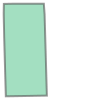

In [ ]:
blocks.the_geom[0]

In [47]:
blocks_geo = gpd.GeoDataFrame(blocks, geometry=(blocks.the_geom))

In [48]:
parks_geo = gpd.GeoDataFrame(parks)

In [49]:
energy_geo = gpd.GeoDataFrame(energy_use, geometry = gpd.points_from_xy(energy_use.longitude, energy_use.latitude))

In [50]:
energy_geo.head()

,location,benchmarking_id,address,chicago_energy_rating,latitude,exempt_from_chicago_energy_rating,community_area,longitude,property_name,data_year,reporting_status,zip_code,number_of_buildings,primary_property_type_epa_calculated,site_eui_kbtu_sq_ft,property_gross_floor_area_epa_calculated_buildings_sq_ft,natural_gas_use_kbtu,year_built,electricity_use_grid_purchase_and_generated_from_onsite_renewable_systems_kbtu,energy_star_score,weather_normalized_site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,water_use_kgal,total_ghg_emissions_metric_tons_co2e,ghg_intensity_metric_tons_co2e_sq_ft,district_chilled_water_use_kbtu,district_steam_use_kbtu,geometry
0,"{'latitude': '41.70649646', 'needs_recoding': ...",159005,821 E 103rd St,0.0,41.706496,False,PULLMAN,-87.602690,Corliss HS -CPS,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.60269 41.70650)
1,"{'latitude': '41.886495', 'needs_recoding': Fa...",256568,363 E Wacker Dr,0.0,41.886495,False,Loop,-87.618105,Vista Tower,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.61810 41.88649)
2,"{'latitude': '41.75582921', 'needs_recoding': ...",100393,7601 S Cicero Ave,NaN,41.755829,True,WEST LAWN,-87.736993,Ford City Mall,2019,Submitted,60652,1.0,Enclosed Mall,144.1,864923.0,11780942.4,1950.0,112895334.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.73699 41.75583)
3,"{'latitude': '41.75629268', 'needs_recoding': ...",100395,7500 S Pulaski Ave,0.0,41.756293,False,WEST LAWN,-87.722240,Daley,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.72224 41.75629)
4,"{'latitude': '42.01036185', 'needs_recoding': ...",100984,1604 1610 W SHERWIN AVE,0.0,42.010362,False,ROGERS PARK,-87.668298,1604 1610 W SHERWIN AVE,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.66830 42.01036)


In [51]:
traffic_geo = gpd.GeoDataFrame(traffic, geometry = gpd.points_from_xy(traffic.longitude, traffic.latitude))

In [52]:
traffic_geo.head()

,:@computed_region_43wa_7qmu,location,vehicle_volume_by_each_direction_of_traffic,date_of_count,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,total_passing_vehicle_volume,traffic_volume_count_location_address,longitude,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,street,:@computed_region_vrxf_vc4k,id,geometry
0,7.0,"{'latitude': '41.887904', 'needs_recoding': Fa...",East Bound: 3600 / West Bound: 3500,2006-11-14T08:00:00.000Z,32.0,41.887904,52.0,7100,5838 West,-87.771064,672.0,22216,Lake St,26.0,414,POINT (-87.77106 41.88790)
1,32.0,"{'latitude': '41.756542', 'needs_recoding': Fa...",East Bound: 3800 / West Bound: 4800,2006-03-28T08:00:00.000Z,61.0,41.756542,31.0,8600,320 East,-87.617335,475.0,21546,76th St,67.0,176,POINT (-87.61733 41.75654)
2,33.0,"{'latitude': '41.792663', 'needs_recoding': Fa...",East Bound: 27800 / West Bound: 25700,2006-08-24T07:00:00.000Z,60.0,41.792663,32.0,53500,1730 East,-87.582231,502.0,22260,57th Dr,8.0,1367,POINT (-87.58223 41.79266)
3,9.0,"{'latitude': '41.849302', 'needs_recoding': Fa...",East Bound: 400 / West Bound: 300,2006-03-30T08:00:00.000Z,40.0,41.849302,48.0,700,125 East,-87.622658,193.0,21194,24th St,34.0,316,POINT (-87.62266 41.84930)
4,47.0,"{'latitude': '41.659177', 'needs_recoding': Fa...",East Bound: 2300 / West Bound: 1900,2006-08-29T07:00:00.000Z,26.0,41.659177,47.0,4200,2924 East,-87.552112,586.0,22250,130th St,52.0,1294,POINT (-87.55211 41.65918)


In [53]:
sjoined_blocks = gpd.sjoin(blocks_geo,energy_geo, how = 'inner')
sjoined_blocks.tail()

,the_geom,statefp10,countyfp10,tractce10,blockce10,geoid10,name10,tract_bloc,geometry,index_right,location,benchmarking_id,address,chicago_energy_rating,latitude,exempt_from_chicago_energy_rating,community_area,longitude,property_name,data_year,reporting_status,zip_code,number_of_buildings,primary_property_type_epa_calculated,site_eui_kbtu_sq_ft,property_gross_floor_area_epa_calculated_buildings_sq_ft,natural_gas_use_kbtu,year_built,electricity_use_grid_purchase_and_generated_from_onsite_renewable_systems_kbtu,energy_star_score,weather_normalized_site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,water_use_kgal,total_ghg_emissions_metric_tons_co2e,ghg_intensity_metric_tons_co2e_sq_ft,district_chilled_water_use_kbtu,district_steam_use_kbtu
500,POLYGON ((-87.63088299949641 41.88197699952518...,17,31,839100,1063,170318391001063,Block 1063,8391001063,"POLYGON ((-87.63088 41.88198, -87.63118 41.881...",433,"{'latitude': '41.88230282', 'needs_recoding': ...",103739,20 N Clark St,4.0,41.882303,False,LOOP,-87.631177,20 N Clark St,2019,Submitted,60602-4109,1.0,Office,41.2,393095.0,NaN,1981.0,16197859.3,81.0,40.5,115.4,NaN,2694.7,6.9,NaN,NaN
500,POLYGON ((-87.63088299949641 41.88197699952518...,17,31,839100,1063,170318391001063,Block 1063,8391001063,"POLYGON ((-87.63088 41.88198, -87.63118 41.881...",401,"{'latitude': '41.8823233', 'needs_recoding': F...",103640,1 N LaSalle St,3.5,41.882323,False,LOOP,-87.632004,One North LaSalle,2019,Submitted,60602-3902,1.0,Office,78.6,554777.0,28422819.5,1929.0,15202711.9,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,"POLYGON ((-87.63563899973363 41.8939699998339,...",17,31,81800,2045,170310818002045,Block 2045,818002045,"POLYGON ((-87.63564 41.89397, -87.63563 41.893...",824,"{'latitude': '41.89392378', 'needs_recoding': ...",119689,303 W Erie St,0.0,41.893924,False,NEAR NORTH SIDE,-87.635812,303 Erie Partners,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,POLYGON ((-87.62235899990246 41.88811200003334...,17,31,320100,2016,170313201002016,Block 2016,3201002016,"POLYGON ((-87.62236 41.88811, -87.62298 41.888...",251,"{'latitude': '41.88764029', 'needs_recoding': ...",101889,333 N Michigan Ave,3.0,41.887640,False,LOOP,-87.624523,333 N Michigan,2019,Submitted,60601,1.0,Office,78.3,354146.0,18849000.0,1928.0,8889072.1,70.0,78.0,126.2,NaN,2480.0,7.0,NaN,NaN
907,POLYGON ((-87.62831699967279 41.90073999992171...,17,31,81201,1002,170310812011002,Block 1002,812011002,"POLYGON ((-87.62832 41.90074, -87.62815 41.900...",843,"{'latitude': '41.90069946', 'needs_recoding': ...",120445,1 - 15 E Oak St,0.0,41.900699,False,NEAR NORTH SIDE,-87.627748,1 - 15 E Oak St,2019,Not Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sjoined_blocks = gpd.sjoin(blocks_geo,energy_geo, how = 'left')
sjoined_blocks.tail()

,the_geom,statefp10,countyfp10,tractce10,blockce10,geoid10,name10,tract_bloc,geometry,index_right,location,benchmarking_id,address,chicago_energy_rating,latitude,exempt_from_chicago_energy_rating,community_area,longitude,property_name,data_year,reporting_status,zip_code,number_of_buildings,primary_property_type_epa_calculated,site_eui_kbtu_sq_ft,property_gross_floor_area_epa_calculated_buildings_sq_ft,natural_gas_use_kbtu,year_built,electricity_use_grid_purchase_and_generated_from_onsite_renewable_systems_kbtu,energy_star_score,weather_normalized_site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,water_use_kgal,total_ghg_emissions_metric_tons_co2e,ghg_intensity_metric_tons_co2e_sq_ft,district_chilled_water_use_kbtu,district_steam_use_kbtu
995,POLYGON ((-87.69148899946701 41.92442400058918...,17,31,221500,2006,170312215002006,Block 2006,2215002006,"POLYGON ((-87.69149 41.92442, -87.68993 41.924...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,POLYGON ((-87.68873700039359 41.92205199995712...,17,31,221500,1012,170312215001012,Block 1012,2215001012,"POLYGON ((-87.68874 41.92205, -87.68875 41.922...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,POLYGON ((-87.68841100033526 41.92122799956369...,17,31,221500,1015,170312215001015,Block 1015,2215001015,"POLYGON ((-87.68841 41.92123, -87.68870 41.921...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,POLYGON ((-87.68982000022429 41.92080199992255...,17,31,221500,2027,170312215002027,Block 2027,2215002027,"POLYGON ((-87.68982 41.92080, -87.69032 41.920...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,POLYGON ((-87.68859599983301 41.91997399992471...,17,31,221500,1014,170312215001014,Block 1014,2215001014,"POLYGON ((-87.68860 41.91997, -87.68869 41.919...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sjoined_blocks.the_geom

0      POLYGON ((-87.62906799941059 41.76908600007152...
1      POLYGON ((-87.6341179992764 41.77446599958471,...
2      POLYGON ((-87.63485400018324 41.77263300022619...
3      POLYGON ((-87.73841099998789 41.85913100037079...
4      POLYGON ((-87.73217300001724 41.85476400046529...
                             ...                        
995    POLYGON ((-87.69148899946701 41.92442400058918...
996    POLYGON ((-87.68873700039359 41.92205199995712...
997    POLYGON ((-87.68841100033526 41.92122799956369...
998    POLYGON ((-87.68982000022429 41.92080199992255...
999    POLYGON ((-87.68859599983301 41.91997399992471...
Name: the_geom, Length: 1002, dtype: object

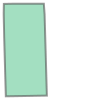

In [ ]:
sjoined_blocks.the_geom[0]

In [ ]:
sjoined_blocks_1 = gpd.sjoin(blocks_geo,traffic_geo, how = 'inner')

In [ ]:
sjoined_blocks_1.head()

,the_geom,statefp10,countyfp10,tractce10,blockce10,geoid10,name10,tract_bloc,geometry,index_right,:@computed_region_43wa_7qmu,location,vehicle_volume_by_each_direction_of_traffic,date_of_count,:@computed_region_rpca_8um6,latitude,:@computed_region_awaf_s7ux,total_passing_vehicle_volume,traffic_volume_count_location_address,longitude,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,street,:@computed_region_vrxf_vc4k,id
47,POLYGON ((-87.66405900044064 41.79768300064323...,17,31,611900,1027,170316119001027,Block 1027,6119001027,"POLYGON ((-87.66406 41.79768, -87.66401 41.795...",431,2.0,"{'latitude': '41.796974', 'needs_recoding': Fa...",North Bound: 17900 / South Bound: 17600,2006-11-15T08:00:00.000Z,37.0,41.796974,19.0,35500,5323 South,-87.664663,790.0,14924,Ashland Ave,59.0,1232
52,POLYGON ((-87.64199899952764 41.69964299998936...,17,31,491100,5022,170314911005022,Block 5022,4911005022,"POLYGON ((-87.64200 41.69964, -87.64201 41.700...",736,22.0,"{'latitude': '41.699648', 'needs_recoding': Fa...",East Bound: 5100 / West Bound: 5800,2006-08-29T07:00:00.000Z,19.0,41.699648,45.0,10900,738 West,-87.641695,525.0,21861,107th St,45.0,470
87,POLYGON ((-87.63885400014951 41.88189000057163...,17,31,281900,3001,170312819003001,Block 3001,2819003001,"POLYGON ((-87.63885 41.88189, -87.63885 41.881...",862,36.0,"{'latitude': '41.881585', 'needs_recoding': Fa...",North Bound: 12100 / / Oneway North Bound,2006-09-19T07:00:00.000Z,46.0,41.881585,48.0,12100,10 South,-87.639674,786.0,14914,Canal St,29.0,857
94,"POLYGON ((-87.53648700031631 41.7119629999973,...",17,31,520200,2011,170315202002011,Block 2011,5202002011,"POLYGON ((-87.53649 41.71196, -87.53625 41.711...",827,47.0,"{'latitude': '41.711118', 'needs_recoding': Fa...",North Bound: 2100 / South Bound: 2100,2006-03-21T08:00:00.000Z,25.0,41.711118,47.0,4200,10129 South,-87.536485,528.0,21202,Avenue L,49.0,157
120,"POLYGON ((-87.7740520002026 41.89882799990965,...",17,31,251300,5008,170312513005008,Block 5008,2513005008,"POLYGON ((-87.77405 41.89883, -87.77355 41.898...",478,7.0,"{'latitude': '41.898376', 'needs_recoding': Fa...",East Bound: 3800 / West Bound: 4800,2006-10-18T07:00:00.000Z,5.0,41.898376,52.0,8600,5937 West,-87.773856,671.0,4299,Augusta Blvd,26.0,1003


In [ ]:
sjoined_blocks_1 = gpd.sjoin(blocks_geo,energy_geo, how = 'left')

In [ ]:
sjoined_blocks_1.head()

,the_geom,statefp10,countyfp10,tractce10,blockce10,geoid10,name10,tract_bloc,geometry,index_right,location,benchmarking_id,address,chicago_energy_rating,latitude,exempt_from_chicago_energy_rating,community_area,longitude,property_name,data_year,reporting_status,zip_code,number_of_buildings,primary_property_type_epa_calculated,site_eui_kbtu_sq_ft,property_gross_floor_area_epa_calculated_buildings_sq_ft,natural_gas_use_kbtu,year_built,electricity_use_grid_purchase_and_generated_from_onsite_renewable_systems_kbtu,energy_star_score,weather_normalized_site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,water_use_kgal,total_ghg_emissions_metric_tons_co2e,ghg_intensity_metric_tons_co2e_sq_ft,district_chilled_water_use_kbtu,district_steam_use_kbtu
0,POLYGON ((-87.62906799941059 41.76908600007152...,17,31,690300,2010,170316903002010,Block 2010,6903002010,"POLYGON ((-87.62907 41.76909, -87.62905 41.768...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-87.6341179992764 41.77446599958471,...",17,31,680900,3007,170316809003007,Block 3007,6809003007,"POLYGON ((-87.63412 41.77447, -87.63410 41.774...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POLYGON ((-87.63485400018324 41.77263300022619...,17,31,680900,3013,170316809003013,Block 3013,6809003013,"POLYGON ((-87.63485 41.77263, -87.63522 41.772...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POLYGON ((-87.73841099998789 41.85913100037079...,17,31,290900,4019,170312909004019,Block 4019,2909004019,"POLYGON ((-87.73841 41.85913, -87.73842 41.859...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POLYGON ((-87.73217300001724 41.85476400046529...,17,31,292500,4016,170312925004016,Block 4016,2925004016,"POLYGON ((-87.73217 41.85476, -87.73226 41.854...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
new_df = gpd.GeoSeries(sjoined_blocks_1.the_geom)

In [54]:
air_quality_geo = gpd.GeoDataFrame(air_quality, geometry = gpd.points_from_xy(air_quality.longitude, air_quality.latitude))

In [55]:
crime_geo = gpd.GeoDataFrame(crime, geometry = gpd.points_from_xy(crime.longitude, crime.latitude))

In [56]:
parks_geo = gpd.GeoDataFrame(parks, geometry = gpd.points_from_xy(parks.longitude, parks.latitude))

## Plots

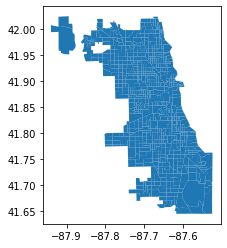

In [37]:
chicago = gpd.read_file('chicago.shp')
chicago.plot()

Text(0.5, 1.0, 'Energy consumption points in Chicago')

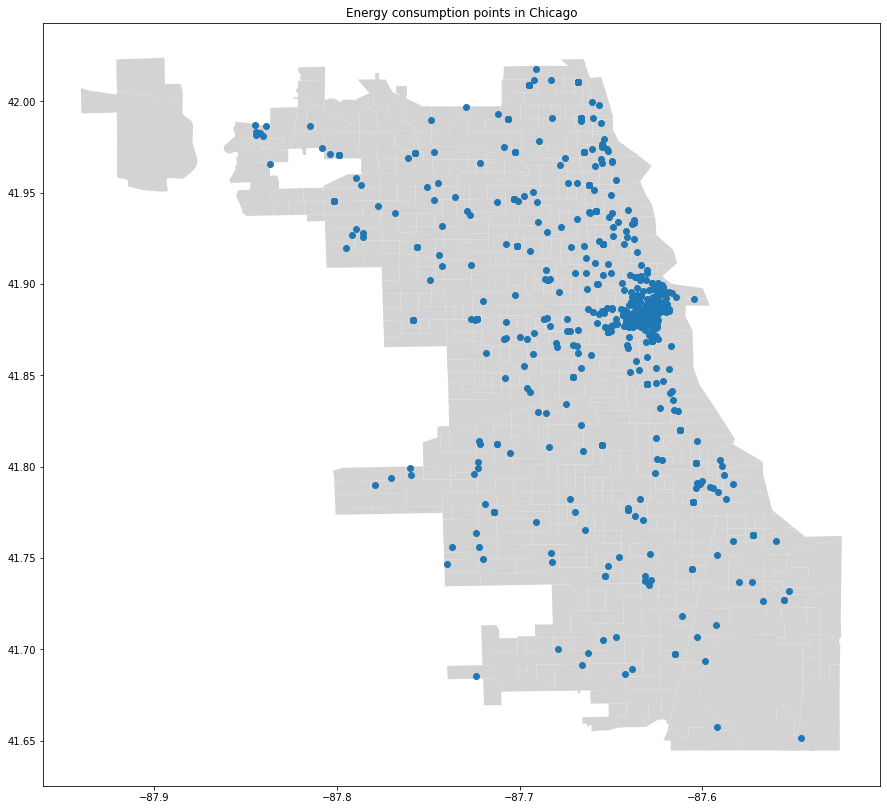

In [58]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
energy_geo.plot(ax = ax)
ax.set_title('Energy consumption points in Chicago')

Text(0.5, 1.0, 'Traffic in Chicago')

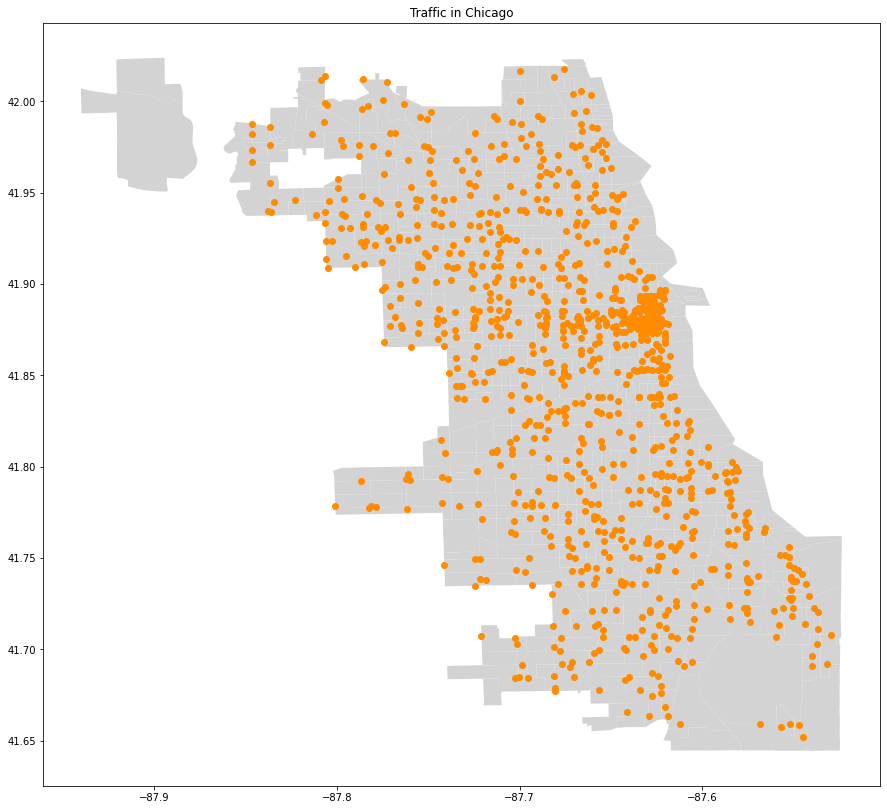

In [59]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
traffic_geo.plot(ax = ax, color='darkorange')
ax.set_title('Traffic in Chicago')

Text(0.5, 1.0, 'Air Quality in Chicago')

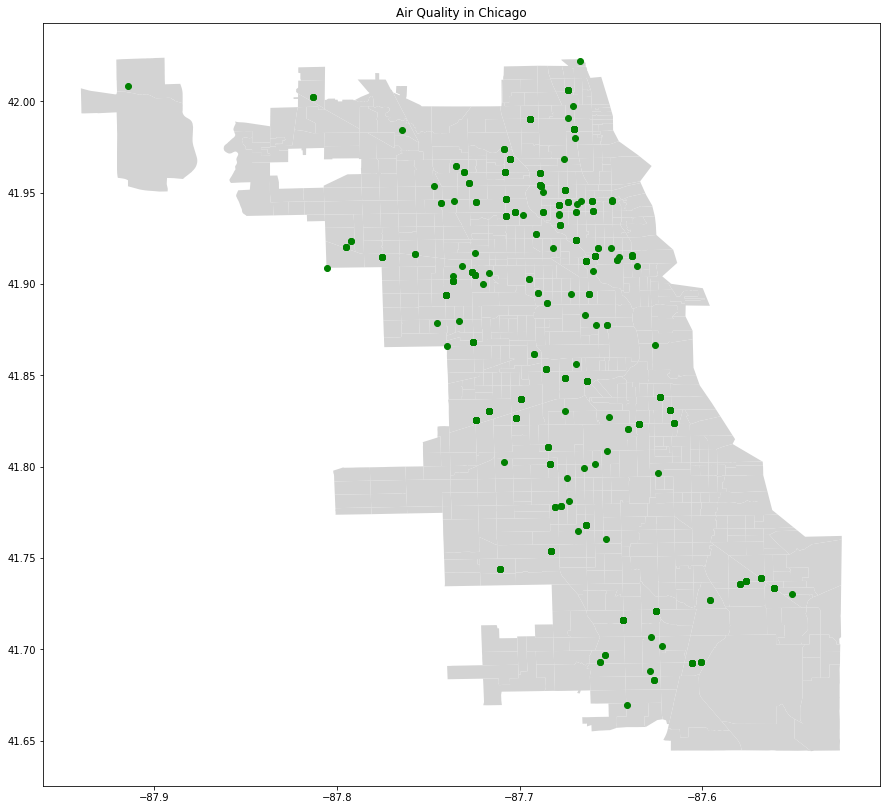

In [60]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
air_quality_geo.plot(ax = ax, color='g')
ax.set_title('Air Quality in Chicago')

Text(0.5, 1.0, 'Crime in Chicago')

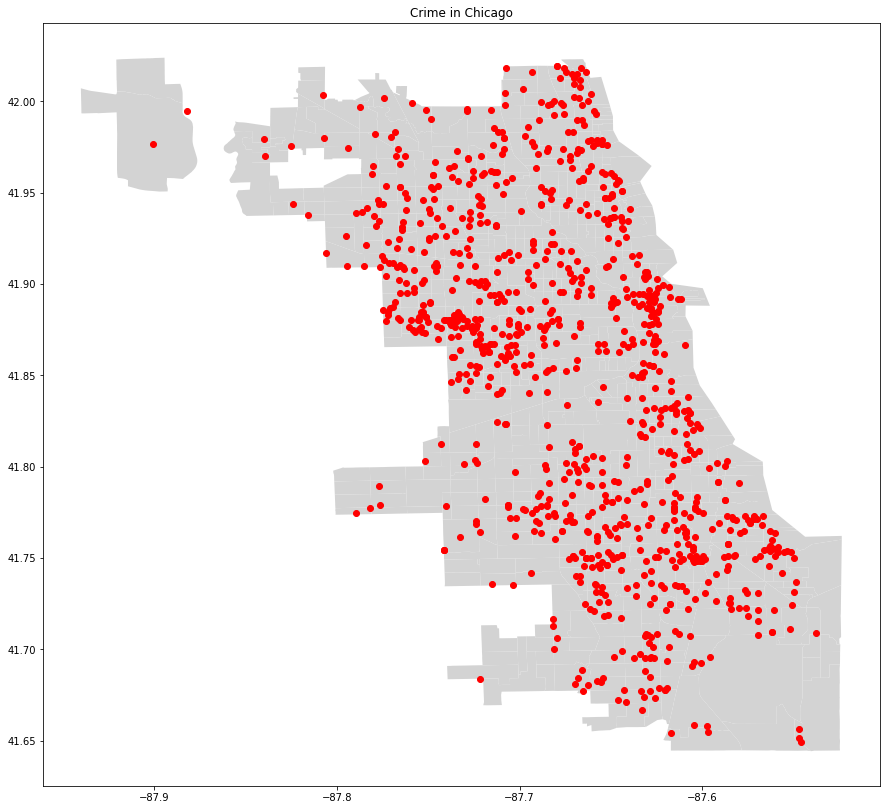

In [61]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
crime_geo.plot(ax = ax, color = 'r')
ax.set_title('Crime in Chicago')

Text(0.5, 1.0, 'Parks in Chicago')

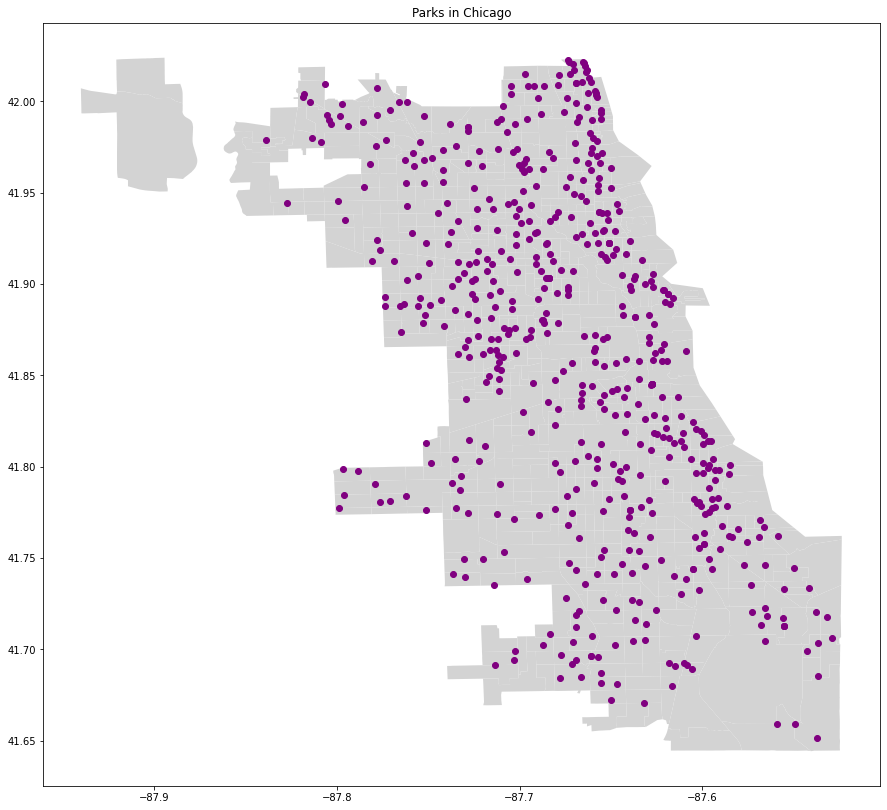

In [65]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
parks_geo.plot(ax = ax, color = 'purple')
ax.set_title('Parks in Chicago')

Text(0.5, 1.0, 'Flu shots in Chicago')

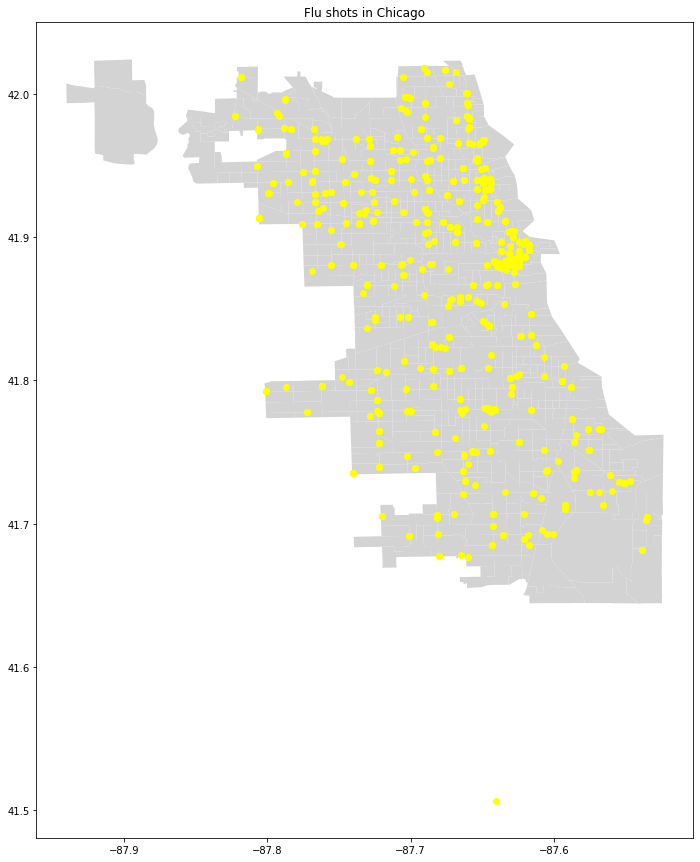

In [78]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
flu_shot_geo.plot(ax = ax, color = 'yellow')
ax.set_title('Flu shots in Chicago')

Text(0.5, 1.0, 'Graffiti in Chicago')

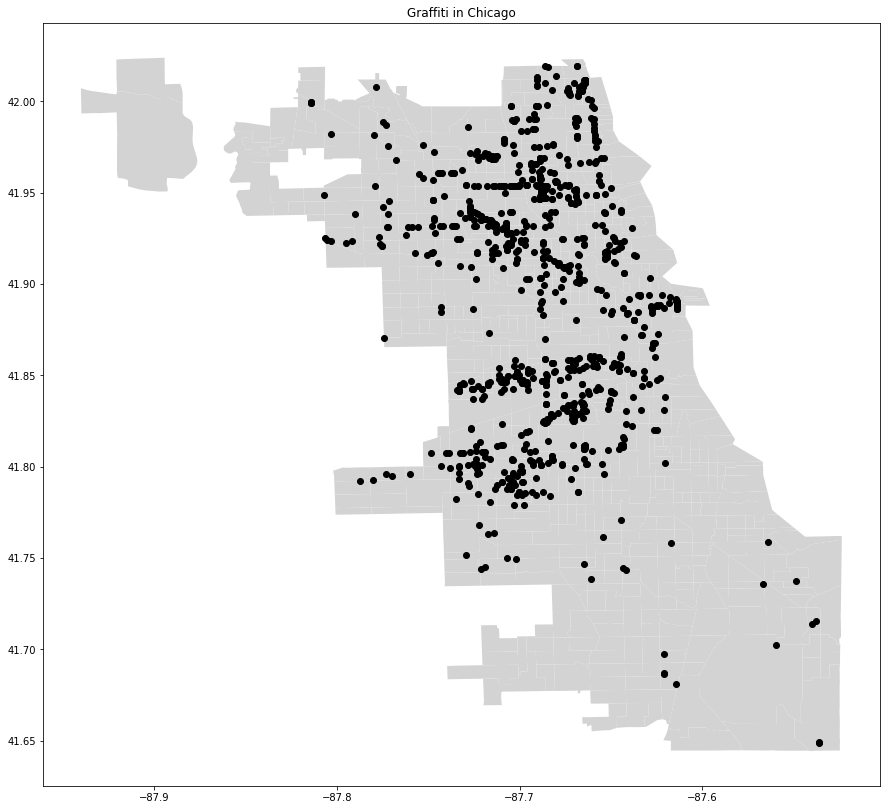

In [74]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
graffiti_geo.plot(ax = ax, color = 'black')
ax.set_title('Graffiti in Chicago')

Text(0.5, 1.0, 'Environmental Inspections in Chicago')

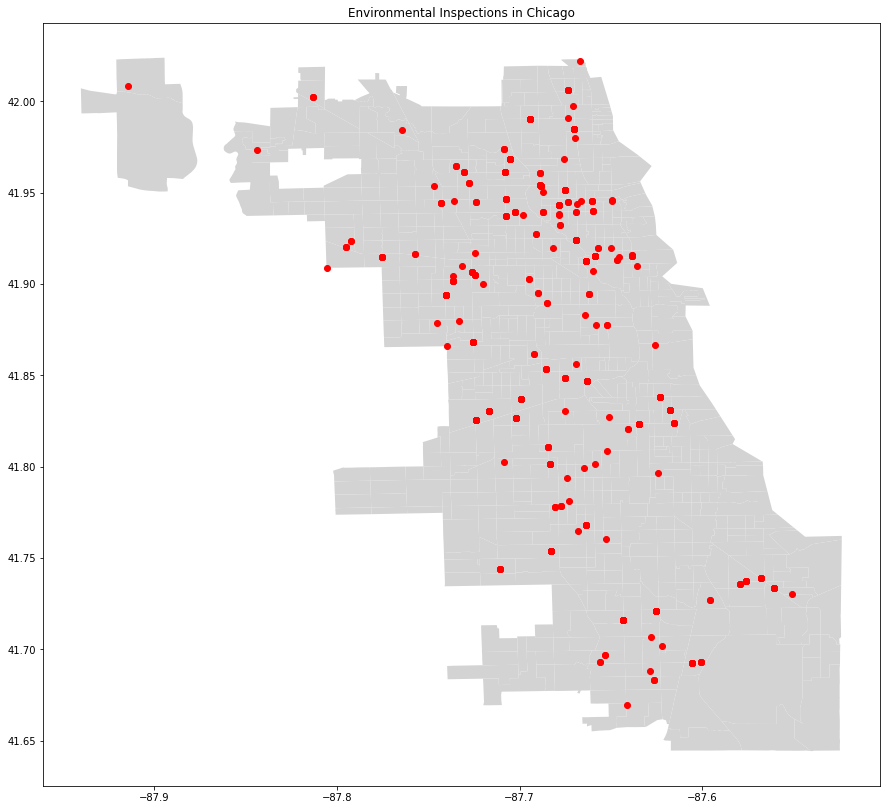

In [82]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
env_insp_geo.plot(ax = ax, color = 'red')
ax.set_title('Environmental Inspections in Chicago')

Text(0.5, 1.0, 'Environmental Complaints in Chicago')

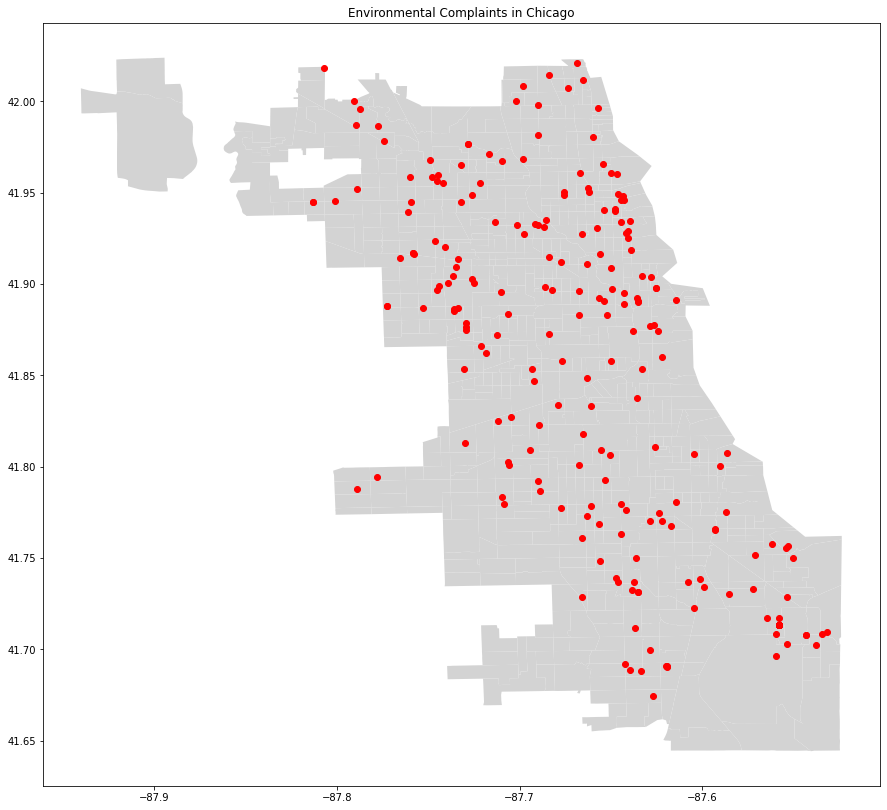

In [38]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
env_complaints_geo.plot(ax = ax, color = 'red')
ax.set_title('Environmental Complaints in Chicago')

Text(0.5, 1.0, 'Beach weather sensor in Chicago')

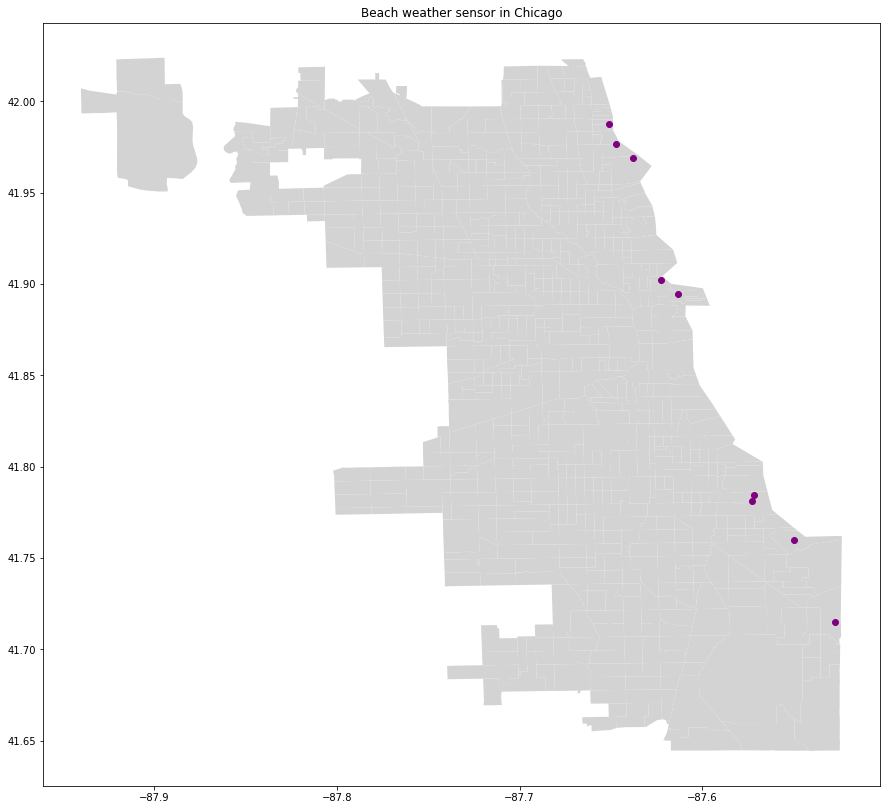

In [69]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
beach_weather_geo.plot(ax = ax, color = 'purple')
ax.set_title('Beach weather sensor in Chicago')

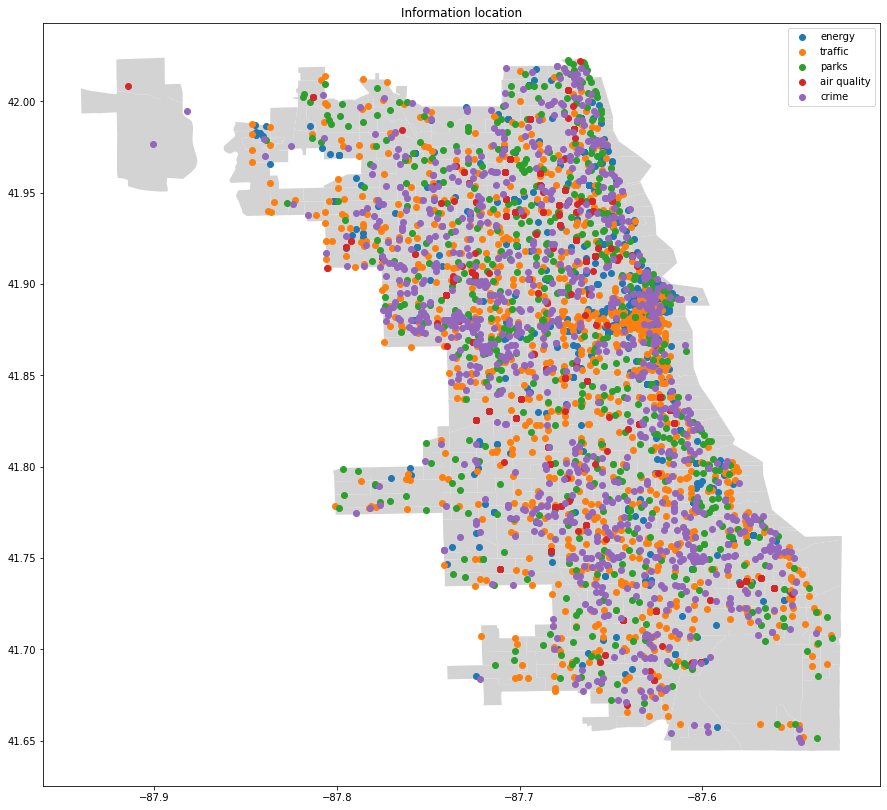

In [64]:
fig, ax = plt.subplots(figsize = (15, 15))
chicago.plot(ax = ax, color ='lightgrey')
energy_geo.plot(ax = ax, label = 'energy')
traffic_geo.plot(ax = ax, label = 'traffic')
parks_geo.plot(ax = ax, label = 'parks')
air_quality_geo.plot(ax = ax, label = 'air quality')
crime_geo.plot(ax = ax, label = 'crime')
ax.set_title('Information location', size = 12)
ax.legend()